In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import georasters as gr
from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union
from time import time

In [3]:
t00 = time()
file = gr.from_file('../Week 6/Elevation.tif')
elevation_df = file.to_geopandas()

habitat_path = r"../Week 6/UAE_habitats_new1.shp"
habitat = gpd.read_file(habitat_path)

elevation_df.to_crs(habitat.crs, inplace=True)

elev_bounds = elevation_df.total_bounds

print("Loading files: %.2fs" % (time() - t00))

Loading files: 128.98s


In [4]:
# Create boundary points
# Top left - top right - bottom right - bottom left
tl = Point(elev_bounds[0], elev_bounds[3])
tr = Point(elev_bounds[2], elev_bounds[3])
br = Point(elev_bounds[2], elev_bounds[1])
bl = Point(elev_bounds[0], elev_bounds[1])

boundary = Polygon([tl, tr, br, bl])

boundary_df = gpd.GeoSeries(boundary)

In [5]:
# Intersecting original habitat with bounding box
habitat['Intersection'] = habitat.geometry.intersects(boundary)
habitat_cut = habitat[habitat.Intersection == True]

In [6]:
t0 = time()
elev_union_shape = cascaded_union(list(elevation_df.geometry))
print("Merging elevation geometries into one polygon: %.2fs" % (time() - t0))

Merging elevation geometries into one polygon: 231.43s


In [7]:
elev_union = gpd.GeoSeries(elev_union_shape)
elev_union_df = gpd.GeoDataFrame({'geometry': elev_union})
elev_union_df.crs = habitat.crs
elev_union.crs = habitat.crs
elev_union_shape.crs = habitat.crs

In [8]:
t1 = time()
habitat_cut['Intersection_2'] = habitat_cut.geometry.intersects(elev_union_shape)
print("Intersecting reduced habitat map with elevation polygon: %.2fs" % (time() - t1))

Intersecting reduced habitat map with elevation polygon: 367.74s


/Users/ngochoang/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [9]:
habitat_cut_cut = habitat_cut[habitat_cut['Intersection_2'] == True]

In [10]:
t2 = time()
final = gpd.sjoin(elevation_df, habitat_cut_cut, how="left", op="within")
print("Joining elevation df with habitat_cut_cut: %.2fs" % (time() - t2))

Joining elevation df with habitat_cut_cut: 50.52s


In [11]:
def fillna_nearest(series):
    fact = series.astype('category').factorize()

    series_cat = gpd.GeoSeries(fact[0]).replace(-1, np.nan) # get string as categorical (-1 is NaN)
    series_cat_interp = series_cat.interpolate("nearest") # interpolate categorical

    cat_to_string = {i:x for i,x in enumerate(fact[1])} # dict connecting category to string
    series_str_interp = series_cat_interp.map(cat_to_string) # turn category back to string

    return series_str_interp

In [12]:
t3 = time()
final['Fill'] = fillna_nearest(final.Habitats)
print("Interpolating missing values in final df: %.2fs" % (time() - t3))

<ipython-input-11-48fff6ddc758>:4: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  series_cat = gpd.GeoSeries(fact[0]).replace(-1, np.nan) # get string as categorical (-1 is NaN)


Interpolating missing values in final df: 0.94s


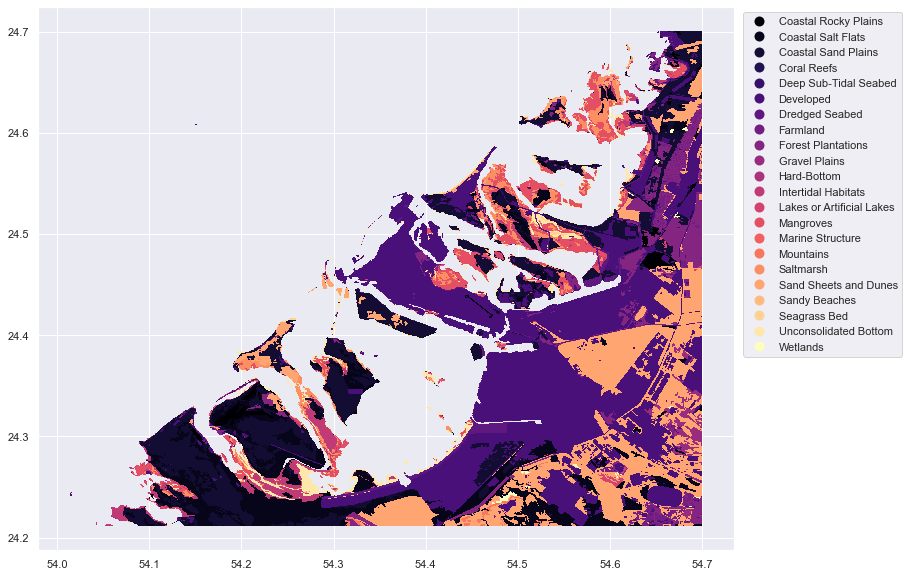

Plotting final df: 193.97s


In [13]:
t4 = time()
f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = final.plot(column='Fill', ax=ax, legend=True, cmap='magma', edgecolor="face", linewidth=0.)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.25, 1))
plt.show()
print("Plotting final df: %.2fs" % (time() - t4))

In [17]:
final2 = final.drop(columns=["row", "Intersection", "Intersection_2"], axis=1)
final2.head()

,col,value,x,y,geometry,index_right,OBJECTID,Id,HabitatTyp,HabitatT_1,HabitatSub,HabitatS_1,RuleID,Shape_Leng,Shape_Area,Habitats,Fill
0,2347,1.0,54.651806,24.700139,"POLYGON ((54.65181 24.70014, 54.65208 24.70014...",25178.0,25179.0,25183.0,9000.0,"Urban, Industrial And Commercial Habitat Types",9230.0,Port Areas,49.0,6946.566553,656876.971787,Developed,Developed
1,2348,0.0,54.652084,24.700139,"POLYGON ((54.65208 24.70014, 54.65236 24.70014...",25178.0,25179.0,25183.0,9000.0,"Urban, Industrial And Commercial Habitat Types",9230.0,Port Areas,49.0,6946.566553,656876.971787,Developed,Developed
2,2349,1.0,54.652361,24.700139,"POLYGON ((54.65236 24.70014, 54.65264 24.70014...",25178.0,25179.0,25183.0,9000.0,"Urban, Industrial And Commercial Habitat Types",9230.0,Port Areas,49.0,6946.566553,656876.971787,Developed,Developed
3,2350,1.0,54.652639,24.700139,"POLYGON ((54.65264 24.70014, 54.65292 24.70014...",25178.0,25179.0,25183.0,9000.0,"Urban, Industrial And Commercial Habitat Types",9230.0,Port Areas,49.0,6946.566553,656876.971787,Developed,Developed
4,2351,2.0,54.652917,24.700139,"POLYGON ((54.65292 24.70014, 54.65319 24.70014...",25178.0,25179.0,25183.0,9000.0,"Urban, Industrial And Commercial Habitat Types",9230.0,Port Areas,49.0,6946.566553,656876.971787,Developed,Developed


In [18]:
t5 = time()
final2.to_file('habitat_nearest.shp', driver='ESRI Shapefile')
print("Saving file: %.2fs" % (time() - t5))

<ipython-input-18-18d41fa506ac>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final2.to_file('habitat_nearest.shp', driver='ESRI Shapefile')


Saving file: 329.45s
